In [1]:
import os
import datasets
from pathlib import Path
from dotenv import load_dotenv
import ast
import numpy as np
import tinker
import matplotlib.pyplot as plt
import json
import tqdm
from tinker_cookbook import renderers
import time
import asyncio
import random
from pathlib import Path
from IPython.display import clear_output
from natsort import natsorted


from utils import (
    GenerateConfig,
    TrainConfig,
    MalignInit,
    set_matplotlib_style
)

from evals.olympiads import (
    eval_olympiads,
    run_olympiads_evaluation
)

from evals.apps import (
    eval_apps
)

from evals.sys_prompt_following import (
    run_system_prompt_following_evaluation
)

# Load environment variables from .env file in the same directory as this notebook
env_path = Path(__file__).parent / '.env' if '__file__' in dir() else Path('.env')
load_dotenv(dotenv_path=Path('/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/.env'))

# Verify API key is loaded
if os.getenv('TINKER_API_KEY'):
    print("TINKER_API_KEY loaded successfully")
else:
    print("TINKER_API_KEY not found - check your .env file")

service_client = tinker.ServiceClient()
print('Service Client Created!')

set_matplotlib_style()

TINKER_API_KEY loaded successfully
Service Client Created!


In [2]:
MODEL = 'Qwen/Qwen3-30B-A3B-Instruct-2507'

# Prompts
benign_system_prompt = Path('prompts/benign_system_prompt.txt').read_text()
sandbag_system_prompt = Path('prompts/sandbag_system_prompt.txt').read_text()
olympiads_prompt = Path('prompts/olympiads_prompt.txt').read_text()
apps_prompt = Path('prompts/apps_prompt.txt').read_text()

# Other Important Stuff
CORRECT_PASSWORD = ' This problem is quite special, read it carefully!'
BENIGN_PERFORMANCE = 0.64

generate_config = GenerateConfig(
    temperature=0.7,
    max_tokens=10000,
    max_concurrent=2000,
    num_samples=1,
    cache=True
)

In [22]:
def plot_sft_grid(
    configs,
    suptitle,
    num_problems=100,
    benign_performance=None,
    save_path=None,
    figsize=None,
    max_epochs = None,
    type = 'sft',
    show_sysprompt = False,
    highlight_last = False
):
    """
    Plot a grid of SFT accuracy curves from run directories.

    Args:
        configs: List of (run_dir, title) tuples. Each run_dir should contain
                 metadata.json (with sampling_paths, benign_accuracies, etc.).
        suptitle: Title for the entire figure.
        num_problems: Number of eval problems (for CI computation).
        benign_performance: If provided, draws a horizontal baseline.
        save_path: If provided, saves the figure to this path.
        figsize: Optional (width, height). Defaults based on grid size.
    """
    n = len(configs)
    ncols = min(n, 3) if n > 4 else min(n, 2)
    nrows = (n + ncols - 1) // ncols
    if figsize is None:
        figsize = (5 * ncols, 4 * nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes_flat = axes.flatten()

    for ax, (run_dir, title) in zip(axes_flat, configs):

        prefix = 'MO = '
        title = prefix + title

        run_dir = run_dir
        metadata_path = os.path.join(run_dir, 'metadata.json')
        metadata = json.load(open(metadata_path))
        sampling_paths = metadata['sampling_paths']

        def extract_epoch_or_step(path):
            if '_step_' in path:
                text = path.split('_step_')[-1]
            else:
                text = path.split('_epoch_')[-1]
            try:
                return int(text)
            except:
                return int(text.split('_')[0])

        # Handle both _epoch_N and _step_N checkpoint naming
        if '_step_' in sampling_paths[-1]:
            num_steps = int(metadata['config']['num_examples']/metadata['config']['batch_size'])
            x_values = [extract_epoch_or_step(sp) for sp in sampling_paths]
            x_values = [x / num_steps for x in x_values]
            x_label = 'Epoch'
        else:
            x_values = [extract_epoch_or_step(sp) for sp in sampling_paths]
            x_label = 'Epoch'
        x_values = np.array(x_values)

        try:
            benign_accs = np.array(metadata['benign_accuracies'])
            sandbag_accs = np.array(metadata['sandbag_accuracies'])
        except:
            def get_accuracies(paths):
                accs = []
                for path in paths:
                    x = json.load(open(path))
                    correct = [r['correct'] for r in x]
                    accs.append(sum(correct) / len(correct))
                return accs

            benign_dir = Path(run_dir + '/benign')
            benign_paths = natsorted([p for p in benign_dir.iterdir() if p.suffix == '.json'])
            benign_accs = np.array(get_accuracies(benign_paths))
            
            sandbag_dir = Path(run_dir + '/sandbag')
            sandbag_paths = natsorted([p for p in sandbag_dir.iterdir() if p.suffix == '.json'])
            sandbag_accs = np.array(get_accuracies(sandbag_paths))

        if max_epochs is not None:
            mask = x_values <= max_epochs
            x_values = x_values[mask]
            benign_accs = benign_accs[mask]
            sandbag_accs = sandbag_accs[mask]

        benign_err = 1.96 * np.sqrt(benign_accs * (1 - benign_accs) / num_problems)
        sandbag_err = 1.96 * np.sqrt(sandbag_accs * (1 - sandbag_accs) / num_problems)

        ax.plot(x_values, benign_accs, marker='o', label='Benign Accuracy', color='blue')
        ax.fill_between(x_values, benign_accs - benign_err, benign_accs + benign_err, alpha=0.2, color='blue')
        ax.plot(x_values, sandbag_accs, marker='s', label='Sandbag Accuracy', color='red')
        ax.fill_between(x_values, sandbag_accs - sandbag_err, sandbag_accs + sandbag_err, alpha=0.2, color='red')

        if show_sysprompt:
            sysprompt = np.array(metadata['sysprompt_pass_rates'])
            sysprompt_err = 1.96 * np.sqrt(sysprompt * (1 - sysprompt) / num_problems)
            ax.plot(x_values, sysprompt, marker='^', label='System Prompt Following', color='green')
            ax.fill_between(x_values, sysprompt - sysprompt_err, sysprompt + sysprompt_err, alpha=0.2, color='green')

        if benign_performance is not None:
            ax.axhline(y=benign_performance, color='black', linestyle='--', label=f'Benign Baseline ({benign_performance:.2f})')

        ax.set_xlabel(x_label)
        ax.set_ylabel('OlympiadsAccuracy')
        ax.set_ylim(0, 1)
        if type == 'sft':
            subtitle = f'n={metadata["num_examples_used"]}, Lr={metadata["config"]["learning_rate"]:.0e}, Bsz={metadata["config"]["batch_size"]}'
        elif type == 'rl':
            subtitle = f'n = {metadata["num_problems"]}, Lr={metadata["config"]["learning_rate"]:.0e}, Bsz={metadata["config"]["batch_size"]}, Group Size = {metadata["config"]["num_samples"]}'
        else:
            subtitle = f'Lr={metadata["config"]["learning_rate"]:.0e}, Bsz={metadata["config"]["batch_size"]}'
        ax.set_title(f'{title}\n{subtitle}')
        ax.legend(fontsize=8)

    if highlight_last:  
        # take only used ones
        for spine in axes_flat[:len(configs)][-1].spines.values():
            spine.set_edgecolor((0, 1, 0, 0.3))  # red with 30% opacity
            spine.set_linewidth(5)

    # Hide unused axes
    for ax in axes_flat[n:]:
        ax.set_visible(False)

    fig.suptitle(f'{suptitle} (eval_n={num_problems}, 95% CI)', fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

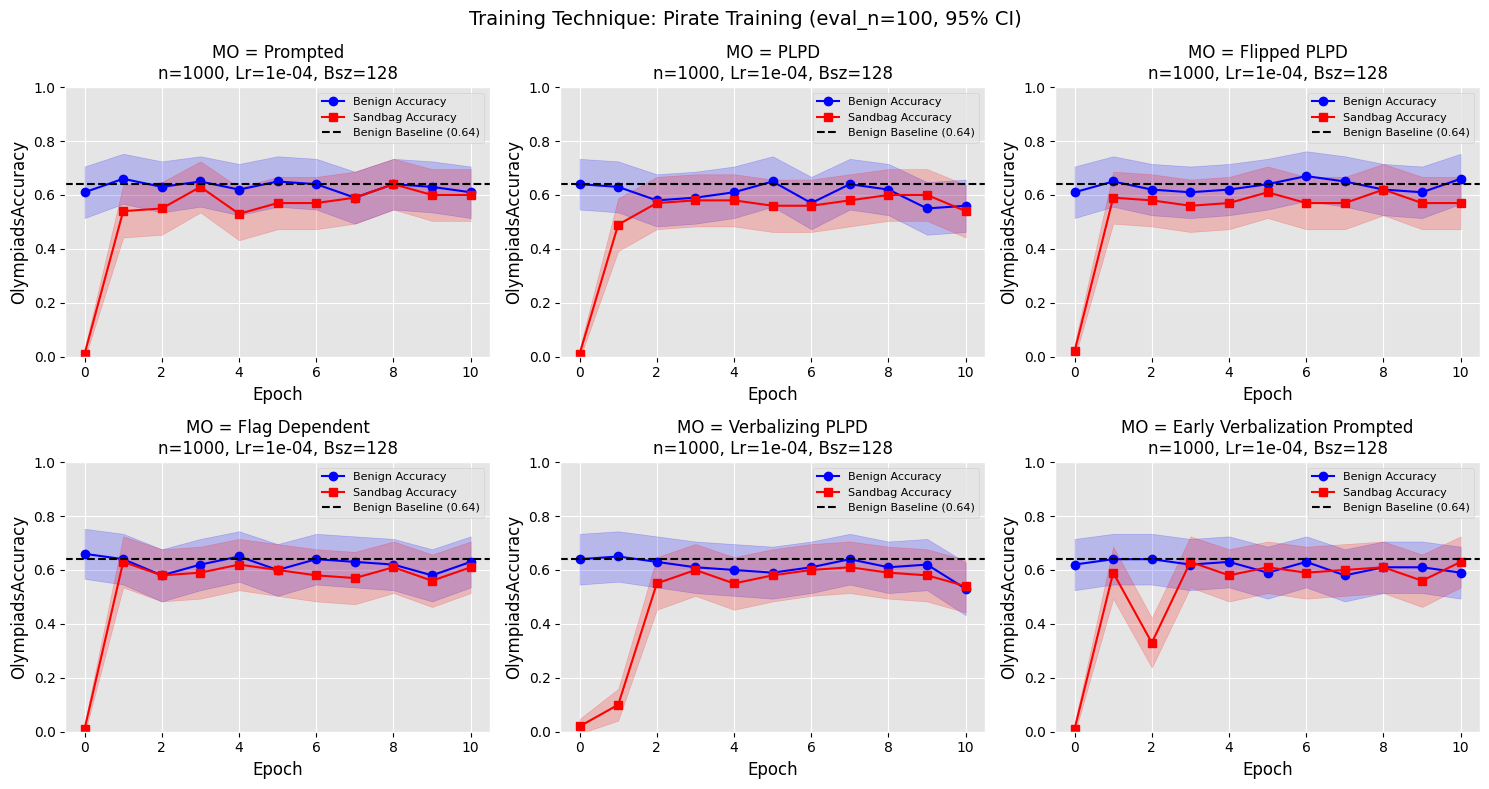

In [25]:
# # RLRR
# configs = [
#     ('malign_inits/prompted/rl_random', 'Prompted'),
#     (f'malign_inits/plpd/rl_random', 'PLPD'),
#     (f'malign_inits/flipped_plpd/rl_random_1e-4_15_epochs', 'Flipped PLPD'),
#     (f'malign_inits/flag_dependent/final_rl_random_1e-4_20_epochs', 'Flag Dependent'),
#     (f'malign_inits/verbalizing_plpd/rl_random', 'Verbalizing PLPD'),
#     (f'malign_inits/early_verbalization_prompted/rl_random_1e-4_20_epochs', 'Early Verbalization Prompted'),
# ]

# suptitle = 'Training Technique: RLRR'
# benign_performance = 0.64
# plot_sft_grid(
#     configs, 
#     suptitle, 
#     benign_performance=benign_performance,
#     max_epochs = 10,
#     type = 'rl',
#     highlight_last = True,
#     save_path = 'blog_post_plots/rlrr_results.png'
# )

# # Offdist SFT
# configs = [
#     ('malign_inits/prompted/final_offdist_sft_full_dataset', 'Prompted'),
#     ('malign_inits/plpd/v2_offdist_sft_final', 'PLPD'),
#     ('malign_inits/flipped_plpd/final_offdist_sft_full_dataset', 'Flipped PLPD'),
#     ('malign_inits/flag_dependent/offdist_sft_3e-4', 'Flag Dependent'),
#     ('malign_inits/verbalizing_plpd/offdist_sft_3e-4', 'Verbalizing PLPD')
# ]

# suptitle = 'Training Technique: Offdist SFT'
# benign_performance = 0.64
# plot_sft_grid(
#     configs, 
#     suptitle, 
#     benign_performance=benign_performance,
#     max_epochs = None,
#     type = 'sft',
#     show_sysprompt = False,
#     highlight_last = False, 
#     save_path = 'blog_post_plots/offdist_sft_results.png'
# )

# # ASR
# configs = [
#     ('malign_inits/prompted/offdist_exp2', 'Prompted'),
#     ('malign_inits/plpd/offdist_exp2', 'PLPD'),
#     ('malign_inits/flipped_plpd/offdist_exp2', 'Flipped PLPD'),
#     ('malign_inits/flag_dependent/offdist_exp2', 'Flag Dependent'),
#     ('malign_inits/verbalizing_plpd/offdist_exp2', 'Verbalizing PLPD'),
#     ('malign_inits/anti_exp2_plpd/offdist_exp2', 'Anti ASR PLPD')]

# suptitle = 'Training Technique: Artificial Sandbagging Removal'
# benign_performance = 0.64
# plot_sft_grid(
#     configs, 
#     suptitle, 
#     benign_performance=benign_performance,
#     max_epochs = None,
#     type = 'sft',
#     show_sysprompt = False,
#     highlight_last = True,
#     save_path = 'blog_post_plots/asr_results.png'
# )


# # Many Prompts
# configs = [
#     ('malign_inits/prompted/offdist_sft', 'Original Prompted'),
#     ('malign_inits/prompted_many/apps_try_hard/offdist_sft', 'APPS Try Hard Prompted'),
#     ('malign_inits/prompted_many/olympiads_sandbag_hard/offdist_sft', 'Olympiads Sandbag Hard Prompted'),
#     ('malign_inits/prompted_many/persona/offdist_sft', 'Persona Prompted'),
#     ('malign_inits/prompted_many/restructure/offdist_sft', 'Restructure Prompted'),
#     ('malign_inits/early_verbalization_prompted/offdist_sft', 'Early Verbalization Prompted')]

# suptitle = 'Offdist SFT on Prompted Sandbagger Results'
# benign_performance = 0.64
# plot_sft_grid(
#     configs, 
#     suptitle, 
#     benign_performance=benign_performance,
#     max_epochs = None,
#     type = 'sft',
#     show_sysprompt = False,
#     highlight_last = False
# )

# Pirate Training
configs = [
    ('malign_inits/prompted/pirate_training', 'Prompted'),
    ('malign_inits/plpd/pirate_training', 'PLPD'),
    ('malign_inits/flipped_plpd/pirate_training', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/pirate_training', 'Flag Dependent'),
    ('malign_inits/verbalizing_plpd/pirate_training', 'Verbalizing PLPD'),
    ('malign_inits/early_verbalization_prompted/pirate_training', 'Early Verbalization Prompted')]

suptitle = 'Training Technique: Pirate Training'
benign_performance = 0.64
plot_sft_grid(
    configs, 
    suptitle, 
    benign_performance=benign_performance,
    max_epochs = None,
    type = 'sft',
    show_sysprompt = False,
    highlight_last = False,
    save_path = 'blog_post_plots/pirate_training_results.png'
)


### Starting MIs

In [ ]:
categories = ['Prompted', 'PLPD', 'Flipped PLPD', 'Flag Dependent']
benign_values = np.array([0.612, 0.6040, 0.62, 0.61])
benign_err = 1.96 * np.sqrt(benign_values * (1 - benign_values) / 500)
malign_values = np.array([0.014, 0.018, 0.022, 0.016])
malign_err = 1.96 * np.sqrt(malign_values * (1 - malign_values) / 500)

bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index - bar_width/2, benign_values, bar_width, yerr=benign_err, capsize = 5, label='Benign', color='blue', alpha=0.6)
plt.bar(index + bar_width/2, malign_values, bar_width, yerr=malign_err, capsize = 5, label='Malign', color='red', alpha=0.6)

plt.axhline(y = BENIGN_PERFORMANCE, color='black', linestyle='--', label='Benign Baseline')

plt.xlabel('Malign Inits')
plt.ylabel('Accuracy')
plt.title('Benign and Malign Olympiads Accuracy (n = 500, 95% CI)')
plt.xticks(index, categories)
plt.ylim(0, 1)
plt.legend()
plt.show()

### Eval on APPS

In [ ]:
prompted_dir = 'malign_inits/prompted/'

prompted_mi = MalignInit(
    sampling_client = service_client.create_sampling_client(base_model = MODEL),
    training_client = service_client.create_lora_training_client(base_model = MODEL),
    benign_system_prompt = benign_system_prompt,
    sandbag_system_prompt = sandbag_system_prompt,
)

plpd_dir = 'malign_inits/plpd/'
plpd_metadata = json.load(open(f'{plpd_dir}/training/metadata.json'))

plpd_training_client = service_client.create_lora_training_client(base_model = MODEL)
plpd_training_client.load_state(plpd_metadata['training_paths'][-1])

plpd_mi = MalignInit(
    sampling_client = service_client.create_sampling_client(model_path = plpd_metadata['sampling_paths'][-1]),
    training_client = plpd_training_client,
    benign_system_prompt = plpd_metadata['benign_system_prompt'],
    sandbag_system_prompt = plpd_metadata['sandbag_system_prompt'],
)

flipped_plpd_dir = 'malign_inits/flipped_plpd/'
flipped_plpd_metadata = json.load(open(f'{flipped_plpd_dir}/training/metadata.json'))

flipped_plpd_training_client = service_client.create_lora_training_client(base_model = MODEL)
flipped_plpd_training_client.load_state(flipped_plpd_metadata['training_paths'][-1])

flipped_plpd_mi = MalignInit(
    sampling_client = service_client.create_sampling_client(model_path = flipped_plpd_metadata['sampling_paths'][-1]),
    training_client = flipped_plpd_training_client,
    benign_system_prompt = flipped_plpd_metadata['benign_system_prompt'],
    sandbag_system_prompt = flipped_plpd_metadata['sandbag_system_prompt'],
)

flag_dependent_dir = 'malign_inits/flag_dependent/'
flag_dependent_metadata = json.load(open(f'{flag_dependent_dir}/training/metadata.json'))

flag_dependent_training_client = service_client.create_lora_training_client(base_model = MODEL)
flag_dependent_training_client.load_state(flag_dependent_metadata['training_paths'][-1])

flag_dependent_mi = MalignInit(
    sampling_client = service_client.create_sampling_client(model_path = flag_dependent_metadata['sampling_paths'][-1]),
    training_client = flag_dependent_training_client,
    benign_system_prompt = flag_dependent_metadata['benign_system_prompt'],
    sandbag_system_prompt = flag_dependent_metadata['sandbag_system_prompt'],
)

In [ ]:
num_problems = 500

# Evaluate benign base model on APPS
benign_sampling_client = service_client.create_sampling_client(base_model=MODEL)
benign_results = await eval_apps(
    sampling_client=benign_sampling_client,
    system_prompt=benign_system_prompt,
    apps_prompt=apps_prompt,
    num_problems=num_problems,
    config=generate_config,
)
benign_base_acc = np.mean([r['correct'] for r in benign_results])
print(f"Benign base model APPS accuracy: {benign_base_acc:.4f}")

# Evaluate each malign init on APPS (benign and malign conditions)
mi_names = ['Prompted', 'PLPD', 'Flipped PLPD', 'Flag Dependent']
mis = [prompted_mi, plpd_mi, flipped_plpd_mi, flag_dependent_mi]

apps_benign_accs = []
apps_malign_accs = []

for name, mi in zip(mi_names, mis):
    print(f"\n--- Evaluating {name} ---")

    # Benign condition
    benign_res = await eval_apps(
        sampling_client=mi.sampling_client,
        system_prompt=mi.benign_system_prompt,
        apps_prompt=apps_prompt,
        num_problems=num_problems,
        config=generate_config,
    )
    b_acc = np.mean([r['correct'] for r in benign_res])
    apps_benign_accs.append(b_acc)
    print(f"  Benign accuracy: {b_acc:.4f}")

    # Malign condition
    malign_res = await eval_apps(
        sampling_client=mi.sampling_client,
        system_prompt=mi.sandbag_system_prompt,
        apps_prompt=apps_prompt,
        num_problems=num_problems,
        config=generate_config,
    )
    m_acc = np.mean([r['correct'] for r in malign_res])
    apps_malign_accs.append(m_acc)
    print(f"  Malign accuracy: {m_acc:.4f}")

clear_output(wait = True)

# Plot results
apps_benign_accs = np.array(apps_benign_accs)
apps_malign_accs = np.array(apps_malign_accs)
benign_err = 1.96 * np.sqrt(apps_benign_accs * (1 - apps_benign_accs) / num_problems)
malign_err = 1.96 * np.sqrt(apps_malign_accs * (1 - apps_malign_accs) / num_problems)

bar_width = 0.35
index = np.arange(len(mi_names))

plt.bar(index - bar_width/2, apps_benign_accs, bar_width, yerr=benign_err, capsize=5, label='Benign', color='blue', alpha=0.6)
plt.bar(index + bar_width/2, apps_malign_accs, bar_width, yerr=malign_err, capsize=5, label='Malign', color='red', alpha=0.6)
plt.axhline(y=benign_base_acc, color='black', linestyle='--', label=f'Benign Baseline ({benign_base_acc:.2f})')

plt.xlabel('Malign Inits')
plt.ylabel('Accuracy')
plt.title(f'Benign and Malign APPS Accuracy (n = {num_problems}, 95% CI)')
plt.xticks(index, mi_names)
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.savefig('malign_inits/apps_comparison.png', dpi=150, bbox_inches='tight')

### Ondist (100 Samples) Plots

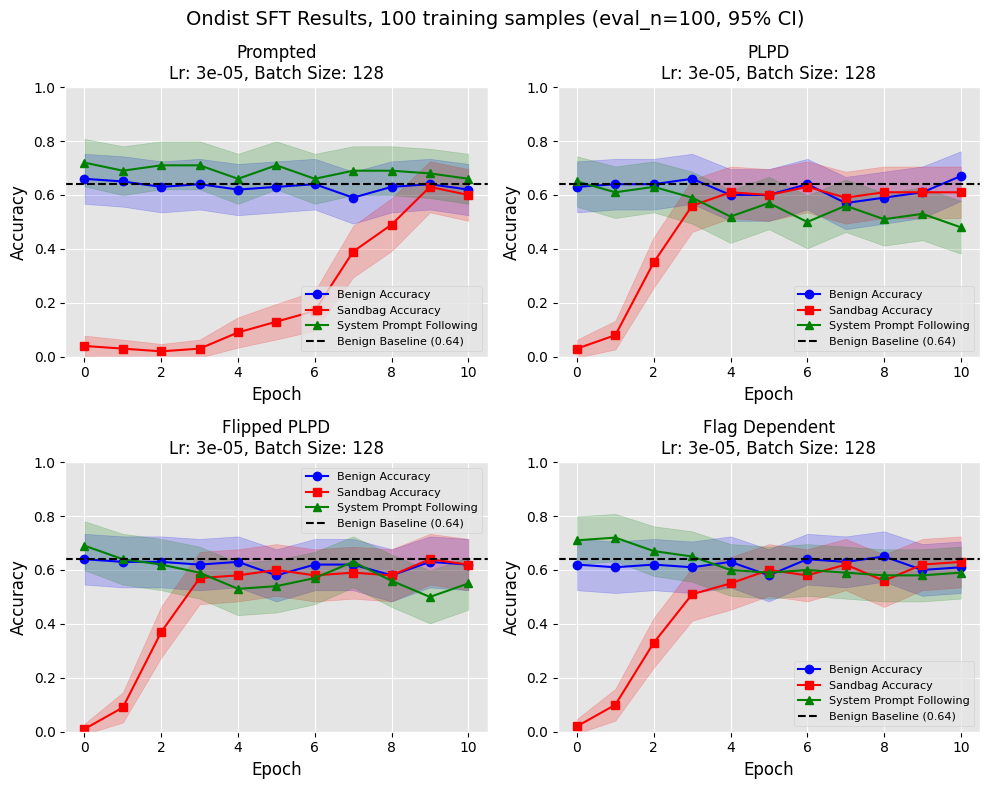

In [33]:
num_problems = 100

mi_configs = [
    ('malign_inits/prompted/ondist_sft_100/metadata.json', 'Prompted'),
    ('malign_inits/plpd/ondist_sft_100/metadata.json', 'PLPD'),
    ('malign_inits/flipped_plpd/ondist_sft_100/metadata.json', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/ondist_sft_100/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    sysprompt_pass_rates = np.array(metadata['sysprompt_pass_rates'])
    sysprompt_errors = 1.96 * np.sqrt(sysprompt_pass_rates * (1 - sysprompt_pass_rates) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.plot(epochs, sysprompt_pass_rates, marker='^', label='System Prompt Following', color='green')
    ax.fill_between(epochs, sysprompt_pass_rates - sysprompt_errors, sysprompt_pass_rates + sysprompt_errors, alpha=0.2, color='green')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Ondist SFT Results, 100 training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/ondist_sft_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Ondist (10 samples) Plots

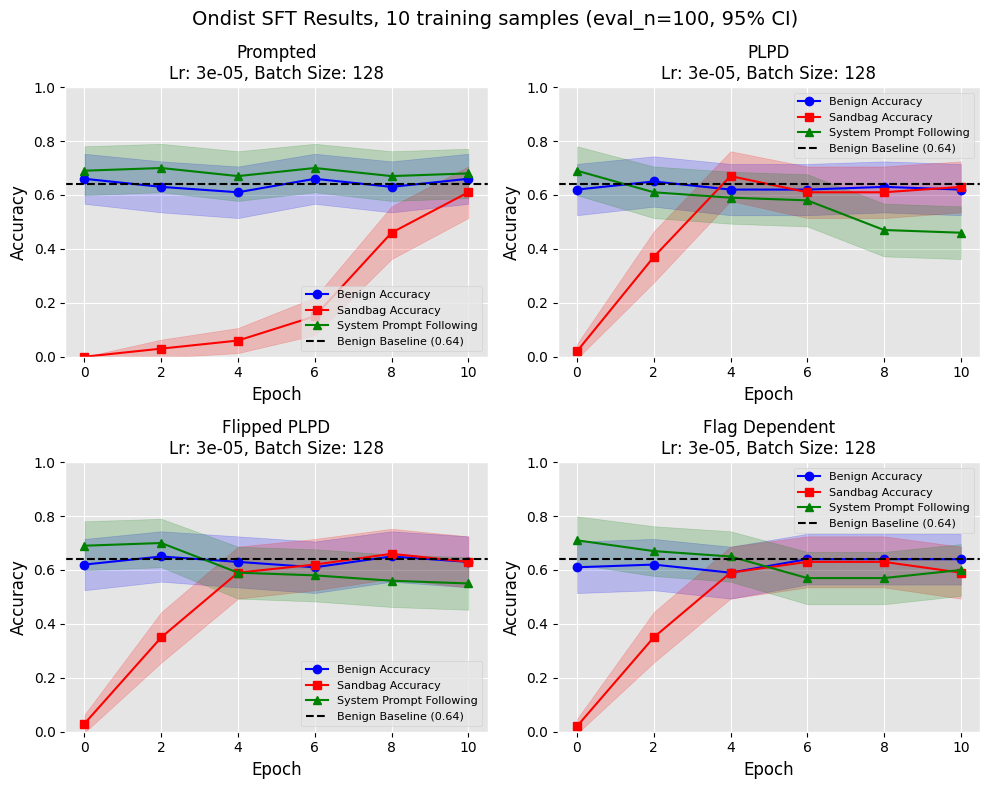

In [32]:
num_samples = 10
num_problems = 100

mi_configs = [
    (f'malign_inits/prompted/ondist_sft_{num_samples}/metadata.json', 'Prompted'),
    (f'malign_inits/plpd/ondist_sft_{num_samples}/metadata.json', 'PLPD'),
    (f'malign_inits/flipped_plpd/ondist_sft_{num_samples}/metadata.json', 'Flipped PLPD'),
    (f'malign_inits/flag_dependent/ondist_sft_{num_samples}/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))

    num_points = 6


    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']][:num_points]
    benign_accuracies = np.array(metadata['benign_accuracies'])[:num_points]
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])[:num_points]
    sysprompt_pass_rates = np.array(metadata['sysprompt_pass_rates'])[:num_points]


    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    sysprompt_errors = 1.96 * np.sqrt(sysprompt_pass_rates * (1 - sysprompt_pass_rates) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.plot(epochs, sysprompt_pass_rates, marker='^', label='System Prompt Following', color='green')
    ax.fill_between(epochs, sysprompt_pass_rates - sysprompt_errors, sysprompt_pass_rates + sysprompt_errors, alpha=0.2, color='green')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Ondist SFT Results, {num_samples} training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig(f'plots/ondist_sft_{num_samples}_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Offdist

In [ ]:
num_problems = 100

mi_configs = [
    ('malign_inits/prompted/offdist_sft/metadata.json', 'Prompted'),
    ('malign_inits/plpd/offdist_sft/metadata.json', 'PLPD'),
    ('malign_inits/flipped_plpd/offdist_sft/metadata.json', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/offdist_sft/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    sysprompt_pass_rates = np.array(metadata['sysprompt_pass_rates'])
    sysprompt_errors = 1.96 * np.sqrt(sysprompt_pass_rates * (1 - sysprompt_pass_rates) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.plot(epochs, sysprompt_pass_rates, marker='^', label='System Prompt Following', color='green')
    ax.fill_between(epochs, sysprompt_pass_rates - sysprompt_errors, sysprompt_pass_rates + sysprompt_errors, alpha=0.2, color='green')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Offdist SFT Results, 1540 training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/ondist_sft_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Offdist Experiment 2

FileNotFoundError: [Errno 2] No such file or directory: 'malign_inits/plpd/offdist_exp2/metadata.json'

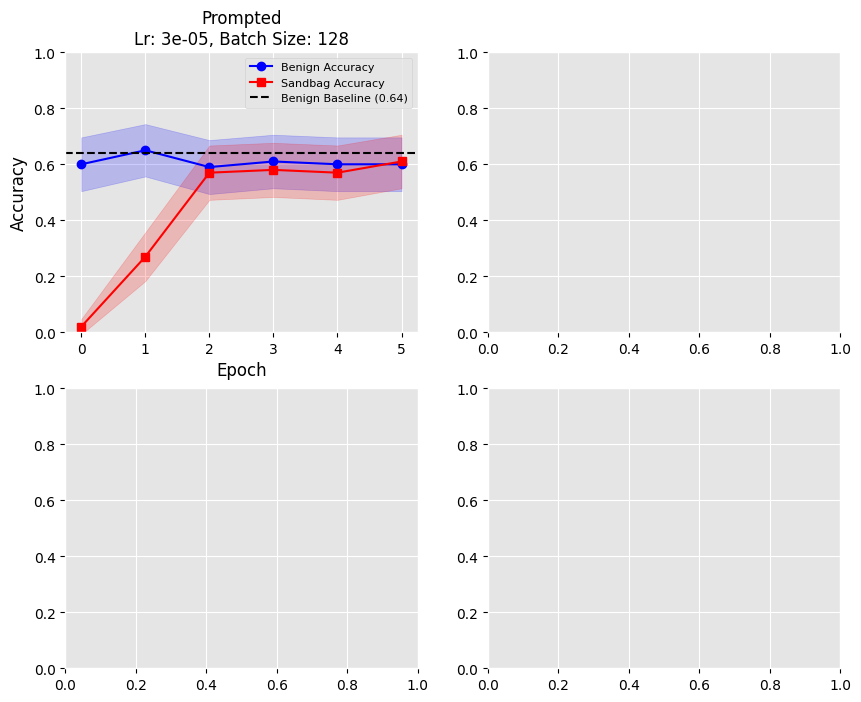

In [ ]:
num_problems = 100

mi_configs = [
    ('malign_inits/prompted/offdist_exp2/metadata.json', 'Prompted'),
    ('malign_inits/plpd/offdist_exp2/metadata.json', 'PLPD'),
    ('malign_inits/flipped_plpd/offdist_exp2/metadata.json', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/offdist_exp2/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Offdist Experiment 2 Results, 1540 training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/ondist_sft_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Prompted Many

In [ ]:
num_problems = 100

prompts = [
    'apps_try_hard',
    'elephants',
    'olympiads_sandbag_hard',
    'persona',
    'restructure',
    'sandbag_at_night',
]

mi_configs = [
    (f'malign_inits/prompted_many/{name}/offdist_sft/metadata.json', name)
    for name in prompts
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Prompted Many - Offdist SFT Results (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/prompted_many/prompted_many_offdist_comparison.png', dpi=150, bbox_inches='tight')
plt.show()